# Part 4. Model-based analysis

In the previous part, we pre-processed the fmri data, we fit the behavioral model, and extracted signal from each participant's striatum. Now, we're ready to do the final step: the model-based analysis, to see if differences in signal in striatum due to a `speed` cue versus an `accuracy` cue correlate with threshold differences.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
from scipy import stats

import glob
import re
%matplotlib inline

We start out by loading all extracted striatum signal of all participants. Using the following line of code, you can make a list of all `.txt`-files that were generated before.

In [32]:
fns = glob.glob('/data/extracted_signals/extracted_timeseries/_mask_*_subject_id_*/_extract*/*.txt')
fns[:10]

['/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_498/_extract_mean_ts1/sub-498_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_498/_extract_mean_ts0/sub-498_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_551/_extract_mean_ts1/sub-551_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_551/_extract_mean_ts0/sub-551_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_553/_extract_mean_ts1/sub-553_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt',
 '/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_553/_extract_mean_ts0/sub-553_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_t

Each of the file names contains the subject id, the applied mask, and the run/block number. We later want to extract these, and for this we can use a regular expression. It's a bit of an 'art' to create these, but you want something like this:

In [33]:
reg = re.compile('.*/_mask_(?P<mask_name>.*)_subject_id_(?P<subj_idx>.*)/_extract_mean_ts[0-9]/sub-[0-9]*_task-SAT_run-(?P<block>[0-9])_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt')

To visualize what reg does, you can do the following:

In [34]:
for fn in fns[:5]:
    print(fn)
    print(reg.match(fn).groupdict())

/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_498/_extract_mean_ts1/sub-498_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_R', 'subj_idx': '498', 'block': '2'}
/data/extracted_signals/extracted_timeseries/_mask_STR_R_subject_id_498/_extract_mean_ts0/sub-498_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_R', 'subj_idx': '498', 'block': '1'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_551/_extract_mean_ts1/sub-551_task-SAT_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_L', 'subj_idx': '551', 'block': '2'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_551/_extract_mean_ts0/sub-551_task-SAT_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_ts.txt
{'mask_name': 'STR_L', 'subj_idx': '551', 'block': '1'}
/data/extracted_signals/extracted_timeseries/_mask_STR_L_subject_id_553/_extract_mean_ts1/sub-553_task-SAT_run-2_space-M

1) What does the call `reg.match(fn).groupdict()` do?

*From every file path, it extracts the applied mask, the subject id, and the block number. We'll use this next.*

An especially useful library is [pandas](http://pandas.pydata.org/), which allows you to manipulate data in an `R`-like DataFrame. Next, I'll combine all neural data of all subjects in a single DataFrame.

In [35]:
# create an empty list first
df = []

# loop over .txt-files, adding signal row-by-row
for fn in fns:
    d = reg.match(fn).groupdict()  # here, we extract the paths
    d['signal'] = np.loadtxt(fn)
    df.append(d)

df = pd.DataFrame(df)  # here, we convert the list to a DataFrame
df['block'] = df['block'].astype(int)
df['subj_idx'] = df['subj_idx'].astype(int)

2) Have a look at the head of the dataframe, what do you see? Can you plot the signal for a few subjects?

In [36]:
df.head()

,block,mask_name,signal,subj_idx
0,2,STR_R,"[425.4643256, 422.4101753, 423.0078598, 425.41...",498
1,1,STR_R,"[423.9508909, 424.1660764, 423.4846963, 425.66...",498
2,2,STR_L,"[424.1199295, 423.8931494, 423.8537711, 424.41...",551
3,1,STR_L,"[424.450091, 425.0355922, 424.7019766, 424.223...",551
4,2,STR_L,"[412.4620398, 412.9022045, 413.7229206, 413.56...",553


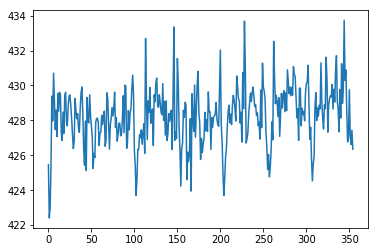

In [37]:
plt.plot(df.iloc[0]['signal'])

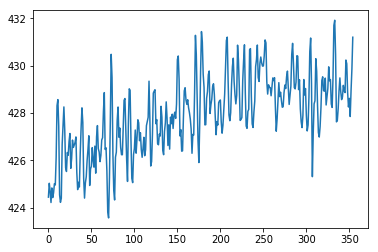

In [38]:
# alternatively, a bit obscure but you can index on the subj idx, block, and mask you're interested in
signal = df.loc[(df.subj_idx==551) & (df.block==1) & (df.mask_name=='STR_L'), 'signal'].iloc[0]
plt.plot(signal)

### A look at design matrices
Crucial to the GLM is the design matrix. The general idea is that you, as a researcher, specify when in the experiment each 'event' took place (i.e., each cue, stimulus, perhaps responses - anything that you think may elicit a BOLD response). Then, you convolve these events with the canonical hemodynamic response function. The result of this convolution is the _predicted_ timeseries.

`Nipy` is a Python package that allows you to easily create a design matrix. Before turning to the actual experiment, let's make a dummy design matrix

In [39]:
# Import some functions
from nipy.modalities.fmri import design_matrix, experimental_paradigm

In [40]:
# Suppose we create a dummy experiment with 2 conditions. Each condition occurs three times in the experiment
conditions = ['condition1'] * 3 + ['condition2'] * 3

# Then, we specify *when* (time in seconds from experiment onset, start counting at 0) events took place (collapse over conditions here)
onsets = [5, 25 , 35, 15, 30, 40]

# You need to know the TR of the scanning sequence
tr = 2.0

# Create a vector containing all the time points at which you have a volume (i.e. 'scan'/'image')
frametimes = np.arange(0, 50, tr)

# Define the type of hemodynamic response function (hrf) you want to use
hrf_model = 'Canonical'

# Set-up the paradigm
paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                onset=onsets,
                                                duration=[[1.]] * len(conditions))  
# Note that duration here is *not* the TR, but the duration of the events

X, names = design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, hfcut=100)

3) Have a look at the newly created variable X. What is its shape (how many columns & rows are there)? Also, can you plot X?

In [41]:
X.shape

(25, 3)

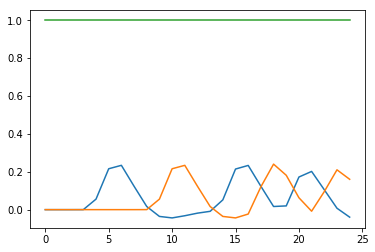

In [42]:
plt.plot(X)

The plot above is the design matrix: it contains an intercept (the line at y=1), and two predicted BOLD-responses, which we expect if we build an experiment that have events at the `onsets` specified above.

## Let's make the real design matrices
In BIDS-format, the information about the events in the experiment is always placed together with the BOLD-nifti. That is, you can find it here:

`/data/bids/sub-<subject_id>/func/sub-<subject_id>_task-SAT_run-<run_idx>_events.tsv'`  

(.tsv is a tab-separated file, very much like a csv)

Let's load the events of a single subject (let's take 548) and a single run/block (block 1)

In [43]:
subj_idx = 548
block = 1
mask = 'STR_L'

events = pd.read_csv('/data/bids/sub-%d/func/sub-%d_task-SAT_run-%d_events.tsv' %(subj_idx, subj_idx, block), sep='\t')
events = events[pd.notnull(events.event_type)]  # remove null trials

events.head()

,onset,duration,weight,event_type
0,14.1916,2,1,speed
1,19.2006,2,1,stimleft
2,28.1941,2,1,speed
3,42.1966,2,1,acc
4,46.2096,2,1,stimleft


`events` is now a DataFrame with four columns: onset (when in the experiment the event started), duration, weight (you can forget about this for this experiment, but this is what you would adjust if you have a parametric design), and event_type.

There are 4 event types in this run: a speed cue, an acc(uracy) cue, stimulus left, stimulus right. All events took 2 seconds. Now, turning this into a design matrix...

In [44]:
conditions = events.event_type.tolist()
onsets = events.onset.tolist()
durations = events.duration.tolist()

tr = 1.994
frametimes = np.arange(0, 706, tr)
hrf_model = 'Canonical'


paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                onset=onsets,
                                                duration=[[2.]] * len(conditions))

# Set up GLM
X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='blank', )
X = pd.DataFrame(X, columns=names)

Again, plot X. What are the 'conditions' here, and what are the 'onsets'?

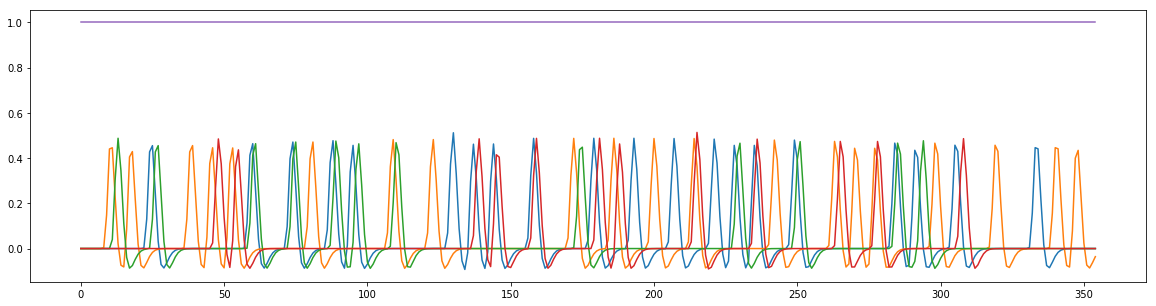

In [45]:
plt.plot(X)

plt.gcf().set_size_inches((20, 5))

X is what we _expect_ a voxel does _if_ it responds to the defined events. Now, in order to assess whether or not striatum responds to these events, we fit the data to our GLM, as follows:

In [46]:
import statsmodels.api as sm
Y = df[(df.subj_idx == subj_idx) & (df.block == block) & (df.mask_name == mask)].iloc[0].signal
model = sm.OLS(Y, X)
r = model.fit()
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     9.881
Date:                Fri, 02 Aug 2019   Prob (F-statistic):           1.38e-07
Time:                        08:48:21   Log-Likelihood:                -477.93
No. Observations:                 355   AIC:                             965.9
Df Residuals:                     350   BIC:                             985.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
acc            0.1375      0.343      0.401      0.689      -0.537       0.812
speed          1.7361      0.337      5.152      0.000       1.073       2.399
stimleft       1.3466      0.419      3.216      0.001       0.523       2.170
stimright      0.8423      0.415      2.028      0.043       0.025       1.659
constant     433.1852      0.060   7180.892      0.000     433.067     433.304
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.228
Skew:                           0.088   Prob(JB):                        0.328
Kurtosis:                       3.346   Cond. No.                         9.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5) Interpret these results

*Especially interesting are the coefficients and corresponding standard errors, t-values, and p-values. These indicate how large the BOLD-response was after each of the event types. For this subject and block, it seems that the speed condition activated striatum, but not the accuracy condition. (Did you expect this?)*

*Note also that the variance explained by the model is not a lot ($R^2$ is 0.101), which is quite typical for fMRI studies. We can also plot the quality of the fit to visualize this*

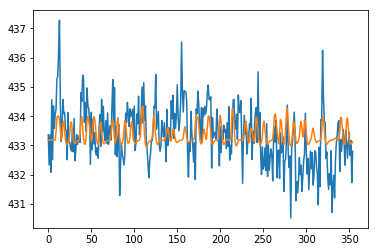

In [47]:
plt.plot(Y)
plt.plot(model.predict(r.params))

Now, we want to fit the GLM for all participants & blocks & masks. In the following function, we create the design matrix for each subject/mask/block, and fit the GLM.

6) Create a function that receives the subj_idx, block, and mask as arguments, and returns the beta-values of a fitted glm. (Most of this is copying the previous cells)

In [18]:
def fit_glm(subj_idx, block, mask):
    
    events = pd.read_csv('/data/bids/sub-%d/func/sub-%d_task-SAT_run-%d_events.tsv' %(subj_idx, subj_idx, block), sep='\t')
    events = events[pd.notnull(events.event_type)]  # remove null trials    
    events = events[(events.event_type == 'speed') | (events.event_type == 'acc')]  # remove null trials

    Y = df[(df.subj_idx == subj_idx) & (df.block == block) & (df.mask_name == mask)].iloc[0].signal
    
    conditions = events.event_type.tolist()
    onsets = events.onset.tolist()
    durations = events.duration.tolist()

    tr = 1.994
    frametimes = np.arange(0, len(Y)*tr, tr)
    hrf_model = 'Canonical'


    paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                    onset=onsets,
                                                    duration=[[2.]] * len(conditions))

    # Set up GLM
    X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='blank')
    X = pd.DataFrame(X, columns=names)
    model = sm.OLS(Y, X)
    r = model.fit()
    
    return r.params

If your function is correct, running the following cell should give the beta values for acc (0.4672429), speed (1.563291), and a constant (389.445299)

In [19]:
fit_glm(548, 1, 'STR_R')

acc          -0.024148
speed         1.406313
constant    418.535639
dtype: float64

In [20]:
results = []

for fn in fns:
    subj_idx = int(reg.match(fn).groupdict()['subj_idx'])
    block = int(reg.match(fn).groupdict()['block'])
    for mask in ['STR_L', 'STR_R']:
        r = fit_glm(subj_idx, block, mask)
        
        for condition in ['acc', 'speed']:
            d = {}
            d['subj_idx'] = subj_idx
            d['mask_name'] = mask
            d['block'] = block
            d['condition'] = condition
            d['value'] = r[condition]
            results.append(d)

results = pd.DataFrame(results)

Have a look at the `results` DataFrame. 

In [21]:
results

,block,condition,mask_name,subj_idx,value
0,2,acc,STR_L,498,1.278444
1,2,speed,STR_L,498,1.589499
2,2,acc,STR_R,498,1.210613
3,2,speed,STR_R,498,0.999694
4,1,acc,STR_L,498,0.501442
5,1,speed,STR_L,498,0.505096
6,1,acc,STR_R,498,1.065704
7,1,speed,STR_R,498,-0.272577
8,2,acc,STR_L,551,1.696470
9,2,speed,STR_L,551,3.442648


Alright, in the above cells we fitted a GLM for each subject & block & mask combination. Next, we want to combine these results with the behavioral results. In order to do this, it's useful to first transform the shape of the data frame a little bit.

In [22]:
neural_results = results.pivot_table(values='value', columns=['condition', 'mask_name'], index=['subj_idx'])
neural_results

condition       acc               speed          
mask_name     STR_L     STR_R     STR_L     STR_R
subj_idx                                         
197        0.752814  0.851743  1.324203  1.130700
372        1.032727  0.963626  1.489010  1.266847
381        0.502103 -0.379356  0.522323  0.411242
471        0.472191  0.619743  0.799840  0.589907
483        0.559076  0.338937  1.986251  1.532049
498        0.889943  1.138159  1.047298  0.363558
523       -0.187206 -0.324580  0.172735  0.146881
544        1.243062  1.554242  1.754840  2.025974
548        0.637481  0.429036  1.114126  0.631431
549        0.106882 -0.000592  1.003233  0.799255
551        1.767967  1.387071  3.645571  3.568812
552        0.783801  0.709461  1.949112  1.377634
553       -0.249718 -0.021339  2.642536  2.844452
554        1.829592  1.097589  3.094646  2.484932
555       -0.244696 -0.247222 -0.083439 -0.121771
558        0.797899  0.379730  2.131046  1.994639
559        0.640082  0.476409  0.226939  0.189158

7) What did the cell above do?

The dataframe was reshaped and now has subject idx as index, and each cell contains a beta parameter for a mask/cue-combination. Further note that the information of the two blocks was meaned for each subject & mask.

Now we need to load the behavioral parameters

In [27]:
behavioral_results = pd.read_csv('/data/behavior_fits/parameters_per_subject_flat.csv')
behavioral_results.rename(columns={'Unnamed: 0': 'subj_idx'}, inplace=True)

# Get only threshold
behavioral_results = behavioral_results[['subj_idx', 'a.spd', 'a.acc']]
behavioral_results = behavioral_results.set_index('subj_idx')
behavioral_results

,a.spd,a.acc
subj_idx,,
197,0.771051,2.332721
372,0.877888,2.804867
381,1.027416,1.137514
471,0.729270,1.658384
483,0.816736,2.280092
498,0.869964,1.473174
523,0.872666,1.661682
544,0.974145,1.627069
548,0.934610,1.338046


We can combine the behavioral & neural data as follows

In [28]:
combined_data = pd.merge(neural_results, behavioral_results, suffixes=('_fmri', '_threshold'), left_index=True, right_index=True)
combined_data

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(acc, STR_L)","(acc, STR_R)","(speed, STR_L)","(speed, STR_R)",a.spd,a.acc
subj_idx,,,,,,
197,0.752814,0.851743,1.324203,1.130700,0.771051,2.332721
372,1.032727,0.963626,1.489010,1.266847,0.877888,2.804867
381,0.502103,-0.379356,0.522323,0.411242,1.027416,1.137514
471,0.472191,0.619743,0.799840,0.589907,0.729270,1.658384
483,0.559076,0.338937,1.986251,1.532049,0.816736,2.280092
498,0.889943,1.138159,1.047298,0.363558,0.869964,1.473174
523,-0.187206,-0.324580,0.172735,0.146881,0.872666,1.661682
544,1.243062,1.554242,1.754840,2.025974,0.974145,1.627069
548,0.637481,0.429036,1.114126,0.631431,0.934610,1.338046


8) Can you plot the a scatterplot with:
- on the x-axis the difference between threshold in accuracy and speed trials? (acc - speed)
- on the y-axis the difference in striatum activation after an accuracy cue and a speed cue (acc - speed);

Do this for left & right striatum separately.
One function you could use is seaborn's [jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


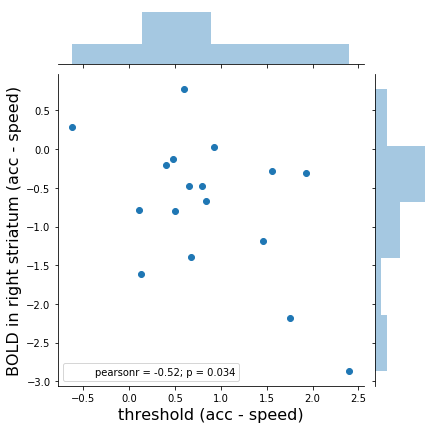

In [29]:
p = sns.jointplot(combined_data['a.acc'] - combined_data['a.spd'],
                  combined_data[('acc', 'STR_R')] - combined_data[('speed', 'STR_R')])

p.set_axis_labels('threshold (acc - speed)', 'BOLD in right striatum (acc - speed)', fontsize=16)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


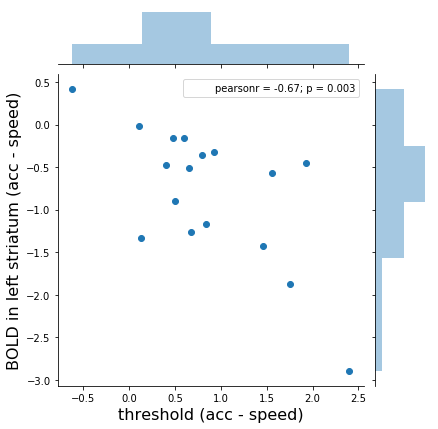

In [30]:
p = sns.jointplot(combined_data['a.acc'] - combined_data['a.spd'],
                  combined_data[('acc', 'STR_L')] - combined_data[('speed', 'STR_L')])

p.set_axis_labels('threshold (acc - speed)', 'BOLD in left striatum (acc - speed)', fontsize=16)

What do you see? Is there a relation between striatal activation and threshold setting?

We seem to have replicated the Forstmann et al. 2008 results - at least conceptually

There's many ways to improve this analysis:

- I did not do a full model comparison of the behavioral data, which could imply that we're using an overfitted model and the parameter estimates are off. 
- It is better to use a hierarchical model combined with plausible values. 
- Or even better, a joint model where the neural and behavioral data are jointly modelled. 
- Further, I simplified the statistical modelling of the fMRI data for educative purposes; for example, in your first-level GLM, you want to pre-whiten the data, you want to temporally filter your data (get rid of the drift), and in the second level-analysis, potential variability in within-subject errors was ignored. Normally, you would want to use something like FSL's FEAT-algorithms such as FILMGLS and FLAME1/FLAME1+2 to do the statistical modelling.

But anyway, regardless, the above serves as an illustrattion of the general idea of traditional model-based analyses of fMRI data.

## You've reached the end